# SINKT Base Individual - Pipeline Completo (Dataset Realista)


## Índice

1. [Instalação e Imports](#1-instalação-e-imports)
2. [Conceitos e Questões Reais](#2-conceitos-e-questões-reais)
3. [Dataset Realista](#3-dataset-realista)
4. [Grafo Conceitual](#4-grafo-conceitual)
5. [Embeddings](#5-embeddings)
6. [Preparação de Dados para GRU](#6-preparação-de-dados-para-gru)
7. [Implementação da GRU](#7-implementação-da-gru)
8. [Treinamento](#8-treinamento)
9. [Predições](#9-predições)
10. [Visualizações e Interpretação](#10-visualizações-e-interpretação)
11. [Mini-Relatório Individual](#11-mini-relatório-individual)

---

## 1. Instalação e Imports

In [6]:
!pip install torch networkx matplotlib pandas numpy scikit-learn python-dotenv -q
!pip install -q -U google-generativeai

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import json
import google.generativeai as genai
import warnings
import time
import re
import os
import io

warnings.filterwarnings('ignore')

# Configurações
np.random.seed(42)
torch.manual_seed(42)

# --- CONFIGURAÇÃO LLM (GEMINI) ---
GOOGLE_API_KEY = "" # Insira sua API Key aqui se desejar executar a parte de geração de grafos

if GOOGLE_API_KEY:
    genai.configure(api_key=GOOGLE_API_KEY)
else:
    print("AVISO: GOOGLE_API_KEY não definida. A geração dinâmica do grafo será simulada ou pulada.")

# --- DADOS EMBUTIDOS (Substituindo arquivos externos) ---

PROMPTS_DATA = {
  "sinkt": {
    "concept_to_related_concepts": {
      "prompt": "Learning order relation refers to relationships that establish a sequential and logical flow for mastering various concepts in a subject. For example, in the subject of mathematics, a student needs to understand the concept of 'integers' before moving on to learn about 'fractions'. Now, a student is learning the concept \"{{TARGET_CONCEPT}}\", which concepts should logically precede this concept to ensure a proper understanding? The candidate concepts are {{CONCEPT_LIST}}. Please choose from the list."
    },
    "question_to_concepts": {
      "prompt": "Given the following question:\n\"{{QUESTION_TEXT}}\"\nAnd the list of available concepts:\n{{CONCEPT_LIST}}\nIdentify which concepts this question belongs to. Choose only from the list and output exactly the selected concepts."
    }
  }
}

CONCEITOS_CSV = """conceito_id,nome,descricao,nivel
variaveis_tipos,Variáveis e Tipos de Dados,"Declaração de variáveis, tipos básicos (int, float, str, bool)",1
operadores,Operadores Aritméticos e Lógicos,"Operações matemáticas, comparação, lógicos",1
condicionais,Estruturas Condicionais (if/elif/else),"Tomada de decisões com if, elif, else",2
loops,Estruturas de Repetição (for/while),"Loops for e while, range(), break, continue",2
funcoes,Funções,"Definição de funções, parâmetros, return, escopo",3
"""

QUESTOES_CSV = """questao_id,conceito_id,enunciado,dificuldade
Q001,variaveis_tipos,Qual é o tipo de dado da variável x = 10?,facil
Q002,variaveis_tipos,Qual código converte o número 42 para string?,facil
Q003,variaveis_tipos,"O que acontece ao executar: nome = ""Ana""; idade = 25; print(nome + idade)?",medio
Q004,operadores,Qual é o resultado de 10 // 3 em Python?,facil
Q005,operadores,Qual é o resultado de 5 > 3 and 2 < 1?,medio
Q006,operadores,O que retorna not (10 == 10 or 5 > 7)?,medio
Q007,condicionais,"Qual será a saída de: x=15; if x>10: print(""A"") elif x>5: print(""B"")?",facil
Q008,condicionais,Qual código verifica se um número é par?,facil
Q009,condicionais,"Condicionais aninhadas: nota=7; if nota>=7: if nota>=9: print(""A"") else: print(""B"")",medio
Q010,loops,"Quantas vezes executa: for i in range(5): print(i)?",facil
Q011,loops,"O que imprime: for i in range(2, 6): print(i)?",medio
Q012,loops,O que faz o break em um loop?,facil
Q013,funcoes,"Qual a saída de: def soma(a,b): return a+b; print(soma(3,5))?",facil
Q014,funcoes,O que acontece se uma função não tem return?,medio
Q015,funcoes,"Parâmetro padrão: def multiplicar(x, y=2): return x*y; print(multiplicar(5))?",medio
"""

def get_gemini_response(prompt_text):
    if not GOOGLE_API_KEY:
        return "{} # API Key não configurada"
    try:
        model = genai.GenerativeModel('gemini-2.0-flash')
        response = model.generate_content(prompt_text)
        return response.text
    except Exception as e:
        return f"Erro na API: {e}"

def build_prompt(template_key, **kwargs):
    template = PROMPTS_DATA['sinkt'][template_key]['prompt']
    for key, value in kwargs.items():
        template = template.replace(f"{{{{{key}}}}}", str(value))
    return template

print("Bibliotecas importadas e ambiente configurado!")
print(f"PyTorch versão: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Bibliotecas importadas e ambiente configurado!
PyTorch versão: 2.9.1+cu128
Device: GPU


---

## 2. Conceitos e Questões Reais

Vamos trabalhar com **conceitos reais de programação Python** e **questões verdadeiras**:

### Conceitos:
1. **Variáveis e Tipos de Dados** - int, float, str, bool
2. **Operadores** - Aritméticos, lógicos, comparação
3. **Condicionais** - if/elif/else
4. **Loops** - for/while, range(), break, continue
5. **Funções** - def, parâmetros, return, escopo

### Questões:
- **15 questões reais** com enunciados, opções e respostas corretas
- **3 questões por conceito**
- **Dificuldades variadas:** fácil, médio

In [8]:
# Carregar conceitos
df_conceitos = pd.read_csv(io.StringIO(CONCEITOS_CSV))
CONCEITOS = {}
for _, row in df_conceitos.iterrows():
    CONCEITOS[row['conceito_id']] = {
        'nome': row['nome'],
        'descricao': row['descricao'],
        'nivel': row['nivel']
    }

# Carregar questões
df_questoes = pd.read_csv(io.StringIO(QUESTOES_CSV))
QUESTOES = {}
for _, row in df_questoes.iterrows():
    QUESTOES[row['questao_id']] = {
        'conceito': row['conceito_id'],
        'enunciado': row['enunciado'],
        'dificuldade': row['dificuldade']
    }

print("Conceitos e questões carregados!")
print(f"\n{len(CONCEITOS)} conceitos de Python")
print(f"{len(QUESTOES)} questões reais")
print("A estrutura de pré-requisitos será gerada dinamicamente pela IA na etapa 4.")

Conceitos e questões carregados!

5 conceitos de Python
15 questões reais
A estrutura de pré-requisitos será gerada dinamicamente pela IA na etapa 4.


In [9]:
# Exibir conceitos
print("CONCEITOS DE PYTHON:\n")
for conceito_id, conceito_data in CONCEITOS.items():
    print(f"- {conceito_data['nome']}")
    print(f"   ID: {conceito_id}")
    print(f"   Nível: {conceito_data['nivel']}")
    print(f"   Descrição: {conceito_data['descricao']}")
    print()

CONCEITOS DE PYTHON:

- Variáveis e Tipos de Dados
   ID: variaveis_tipos
   Nível: 1
   Descrição: Declaração de variáveis, tipos básicos (int, float, str, bool)

- Operadores Aritméticos e Lógicos
   ID: operadores
   Nível: 1
   Descrição: Operações matemáticas, comparação, lógicos

- Estruturas Condicionais (if/elif/else)
   ID: condicionais
   Nível: 2
   Descrição: Tomada de decisões com if, elif, else

- Estruturas de Repetição (for/while)
   ID: loops
   Nível: 2
   Descrição: Loops for e while, range(), break, continue

- Funções
   ID: funcoes
   Nível: 3
   Descrição: Definição de funções, parâmetros, return, escopo



In [10]:
# Exibir algumas questões
print("EXEMPLOS DE QUESTÕES:\n")
for q_id in ['Q001', 'Q004', 'Q007', 'Q010', 'Q013']:
    q = QUESTOES[q_id]
    conceito_nome = CONCEITOS[q['conceito']]['nome']
    print(f"- {q_id} - [{conceito_nome}]")
    print(f"   {q['enunciado']}")
    print(f"   Dificuldade: {q['dificuldade']}")
    print()

EXEMPLOS DE QUESTÕES:

- Q001 - [Variáveis e Tipos de Dados]
   Qual é o tipo de dado da variável x = 10?
   Dificuldade: facil

- Q004 - [Operadores Aritméticos e Lógicos]
   Qual é o resultado de 10 // 3 em Python?
   Dificuldade: facil

- Q007 - [Estruturas Condicionais (if/elif/else)]
   Qual será a saída de: x=15; if x>10: print("A") elif x>5: print("B")?
   Dificuldade: facil

- Q010 - [Estruturas de Repetição (for/while)]
   Quantas vezes executa: for i in range(5): print(i)?
   Dificuldade: facil

- Q013 - [Funções]
   Qual a saída de: def soma(a,b): return a+b; print(soma(3,5))?
   Dificuldade: facil



---

## 3. Dataset Realista

Criar um dataset simulando **10 alunos** respondendo as **15 questões reais**.

In [11]:
# Definir alunos
alunos = [f'Aluno_{i}' for i in range(1, 11)]  # Aluno_1 a Aluno_10

# Criar mapeamento dificuldade -> probabilidade base
dificuldade_prob = {
    'facil': 0.75,
    'medio': 0.55,
    'dificil': 0.35
}

# Gerar dataset
data = []

for aluno in alunos:
    # Cada aluno tem um nível de proficiência geral (0.3 a 0.9)
    proficiencia_geral = np.random.uniform(0.3, 0.9)
    
    # Cada aluno responde 5 questões aleatórias
    questoes_aluno = np.random.choice(list(QUESTOES.keys()), size=5, replace=True)
    
    for questao_id in questoes_aluno:
        questao = QUESTOES[questao_id]
        conceito_id = questao['conceito']
        dificuldade = questao['dificuldade']
        
        # Probabilidade de acerto = proficiência do aluno × prob. base da dificuldade
        prob_base = dificuldade_prob[dificuldade]
        prob_acerto = proficiencia_geral * prob_base
        
        # Adicionar variabilidade
        prob_acerto += np.random.uniform(-0.1, 0.1)
        prob_acerto = np.clip(prob_acerto, 0, 1)
        
        # Determinar acerto
        acerto = 1 if np.random.random() < prob_acerto else 0
        
        data.append({
            'aluno': aluno,
            'questao_id': questao_id,
            'questao_texto': questao['enunciado'][:50] + '...',  # Resumo
            'conceito_id': conceito_id,
            'conceito_nome': CONCEITOS[conceito_id]['nome'],
            'dificuldade': dificuldade,
            'acerto': acerto
        })

# Criar DataFrame
df = pd.DataFrame(data)
df['timestamp'] = range(len(df))

print(f"Dataset criado com {len(df)} tentativas")
print(f"\nDistribuição:")
print(f"   - Alunos: {df['aluno'].nunique()}")
print(f"   - Conceitos: {df['conceito_id'].nunique()}")
print(f"   - Questões únicas: {df['questao_id'].nunique()}")
print(f"   - Taxa de acerto geral: {df['acerto'].mean():.2%}")

print(f"\nPrimeiras 10 tentativas:")
df.head(10)

Dataset criado com 50 tentativas

Distribuição:
   - Alunos: 10
   - Conceitos: 5
   - Questões únicas: 15
   - Taxa de acerto geral: 38.00%

Primeiras 10 tentativas:


,aluno,questao_id,questao_texto,conceito_id,conceito_nome,dificuldade,acerto,timestamp
0,Aluno_1,Q013,"Qual a saída de: def soma(a,b): return a+b; pr...",funcoes,Funções,facil,0,0
1,Aluno_1,Q015,"Parâmetro padrão: def multiplicar(x, y=2): ret...",funcoes,Funções,medio,0,1
2,Aluno_1,Q011,"O que imprime: for i in range(2, 6): print(i)?...",loops,Estruturas de Repetição (for/while),medio,1,2
3,Aluno_1,Q008,Qual código verifica se um número é par?...,condicionais,Estruturas Condicionais (if/elif/else),facil,1,3
4,Aluno_1,Q013,"Qual a saída de: def soma(a,b): return a+b; pr...",funcoes,Funções,facil,0,4
5,Aluno_2,Q012,O que faz o break em um loop?...,loops,Estruturas de Repetição (for/while),facil,0,5
6,Aluno_2,Q005,Qual é o resultado de 5 > 3 and 2 < 1?...,operadores,Operadores Aritméticos e Lógicos,medio,0,6
7,Aluno_2,Q001,Qual é o tipo de dado da variável x = 10?...,variaveis_tipos,Variáveis e Tipos de Dados,facil,0,7
8,Aluno_2,Q012,O que faz o break em um loop?...,loops,Estruturas de Repetição (for/while),facil,0,8
9,Aluno_2,Q010,Quantas vezes executa: for i in range(5): prin...,loops,Estruturas de Repetição (for/while),facil,1,9


In [12]:
# Estatísticas por conceito
print("Desempenho por Conceito:\n")
conceito_stats = df.groupby('conceito_nome').agg({
    'acerto': ['count', 'sum', 'mean']
}).round(3)
conceito_stats.columns = ['Total_Tentativas', 'Total_Acertos', 'Taxa_Acerto']
print(conceito_stats.sort_values('Taxa_Acerto', ascending=False))

Desempenho por Conceito:

                                        Total_Tentativas  Total_Acertos  \
conceito_nome                                                             
Estruturas Condicionais (if/elif/else)                13              7   
Estruturas de Repetição (for/while)                   12              5   
Funções                                               11              4   
Operadores Aritméticos e Lógicos                       4              1   
Variáveis e Tipos de Dados                            10              2   

                                        Taxa_Acerto  
conceito_nome                                        
Estruturas Condicionais (if/elif/else)        0.538  
Estruturas de Repetição (for/while)           0.417  
Funções                                       0.364  
Operadores Aritméticos e Lógicos              0.250  
Variáveis e Tipos de Dados                    0.200  


In [13]:
# Estatísticas por aluno
print("Desempenho por Aluno:\n")
aluno_stats = df.groupby('aluno').agg({
    'acerto': ['count', 'sum', 'mean']
}).round(3)
aluno_stats.columns = ['Total_Tentativas', 'Total_Acertos', 'Taxa_Acerto']
print(aluno_stats.sort_values('Taxa_Acerto', ascending=False))

Desempenho por Aluno:

          Total_Tentativas  Total_Acertos  Taxa_Acerto
aluno                                                 
Aluno_10                 5              3          0.6
Aluno_3                  5              3          0.6
Aluno_4                  5              3          0.6
Aluno_1                  5              2          0.4
Aluno_5                  5              2          0.4
Aluno_8                  5              2          0.4
Aluno_2                  5              1          0.2
Aluno_6                  5              1          0.2
Aluno_7                  5              1          0.2
Aluno_9                  5              1          0.2


---

## 4. Grafo Conceitual

Estrutura de pré-requisitos entre os conceitos de Python.

### Integração com LLM: Fase Indutiva e Cold Start

Nesta etapa, utilizamos a API do **Google Gemini** (`gemini-2.0-flash`) para demonstrar a capacidade **"Indutiva"** do SINKT. Isso resolve o problema do *Cold Start* (quando não temos dados históricos suficientes para definir a ordem dos conteúdos).

**O que acontece aqui:**
1.  **Geração de Topologia:** A IA analisa os nomes dos conceitos e define quem é pré-requisito de quem, gerando o Grafo de Dependências automaticamente.
2.  **Relação com a GRU:** Em um pipeline de produção completo (SINKT Full), este grafo informaria a matriz de adjacência ou inicializaria os embeddings do modelo para garantir que a rede neural "saiba" a ordem das matérias antes mesmo de ver o primeiro aluno. **Neste notebook de demonstração**, geramos o grafo para validar essa capacidade, enquanto a GRU (nas seções seguintes) treina com os dados simulados e aprende suas próprias representações vetoriais (embeddings) a partir do zero, correlacionando-as com o desempenho dos alunos.

In [14]:
# --- GERAÇÃO DINÂMICA DO GRAFO VIA LLM ---

print("=== Fase Indutiva: Gerando Topologia do Grafo com Gemini ===\n")

GRAFO_PREREQUISITOS = []
all_concept_names = [c['nome'] for c in CONCEITOS.values()]

if not GOOGLE_API_KEY:
    print("!!! PULANDO GERAÇÃO DE GRAFO (API Key não detectada) !!!")
    print("Usando estrutura padrão simplificada para visualização apenas.")
    # Fallback simples para não quebrar a visualização se o usuário não puser a chave
    GRAFO_PREREQUISITOS = [
        ('variaveis_tipos', 'operadores'),
        ('operadores', 'condicionais'),
        ('condicionais', 'loops'),
        ('loops', 'funcoes')
    ]
else:
    # Iterar sobre cada conceito para descobrir seus pré-requisitos
    for conceito_id, dados in CONCEITOS.items():
        target_concept = dados['nome']
        # Candidatos são todos menos o próprio
        candidates = [name for name in all_concept_names if name != target_concept]
        
        # Construir Prompt
        prompt = build_prompt('concept_to_related_concepts', 
                              TARGET_CONCEPT=target_concept, 
                              CONCEPT_LIST=", ".join(candidates))
        prompt += "\n\nIMPORTANT: Return the result strictly in JSON format with a key 'prerequisites' containing the list of selected concept names from the candidates. Do not include any explanation, just the JSON."
        
        print(f"Analisando conceito: {target_concept}...")
        
        # Chamar LLM
        resp = get_gemini_response(prompt)
        
        # Processar Resposta
        try:
            json_str = re.search(r'\{.*\}', resp, re.DOTALL)
            if json_str:
                json_obj = json.loads(json_str.group(0))
                prereqs = json_obj.get('prerequisites', [])
                
                if not prereqs:
                    print(f"   -> Nenhum pré-requisito identificado (Conceito Base).")
                
                for p_name in prereqs:
                    # Mapear Nome -> ID
                    p_id = next((cid for cid, cdata in CONCEITOS.items() if cdata['nome'] == p_name), None)
                    if p_id:
                        GRAFO_PREREQUISITOS.append((p_id, conceito_id))
                        print(f"   -> Pré-requisito adicionado: {p_name}")
                    else:
                        pass
            else:
                print(f"   -> Falha ao ler resposta da IA.")
                
        except Exception as e:
            print(f"   -> Erro: {e}")
        
        time.sleep(1) # Evitar rate limit

# Construir Grafo NetworkX
G = nx.DiGraph()
G.add_nodes_from(CONCEITOS.keys())
G.add_edges_from(GRAFO_PREREQUISITOS)

print(f"\nGrafo construído com sucesso!")
print(f"Nós: {G.number_of_nodes()} | Arestas: {G.number_of_edges()}")

print(f"\nEstrutura Final de Pré-requisitos:\n")
for conceito_id in CONCEITOS.keys():
    conceito_nome = CONCEITOS[conceito_id]['nome']
    predecessores = [CONCEITOS[p]['nome'] for p in G.predecessors(conceito_id)]
    print(f"- {conceito_nome}")
    print(f"   Pré-requisitos: {predecessores if predecessores else 'Nenhum'}")
    print()

=== Fase Indutiva: Gerando Topologia do Grafo com Gemini ===

Analisando conceito: Variáveis e Tipos de Dados...
   -> Falha ao ler resposta da IA.
Analisando conceito: Operadores Aritméticos e Lógicos...
   -> Falha ao ler resposta da IA.
Analisando conceito: Estruturas Condicionais (if/elif/else)...
   -> Falha ao ler resposta da IA.
Analisando conceito: Estruturas de Repetição (for/while)...
   -> Falha ao ler resposta da IA.
Analisando conceito: Funções...
   -> Falha ao ler resposta da IA.

Grafo construído com sucesso!
Nós: 5 | Arestas: 0

Estrutura Final de Pré-requisitos:

- Variáveis e Tipos de Dados
   Pré-requisitos: Nenhum

- Operadores Aritméticos e Lógicos
   Pré-requisitos: Nenhum

- Estruturas Condicionais (if/elif/else)
   Pré-requisitos: Nenhum

- Estruturas de Repetição (for/while)
   Pré-requisitos: Nenhum

- Funções
   Pré-requisitos: Nenhum



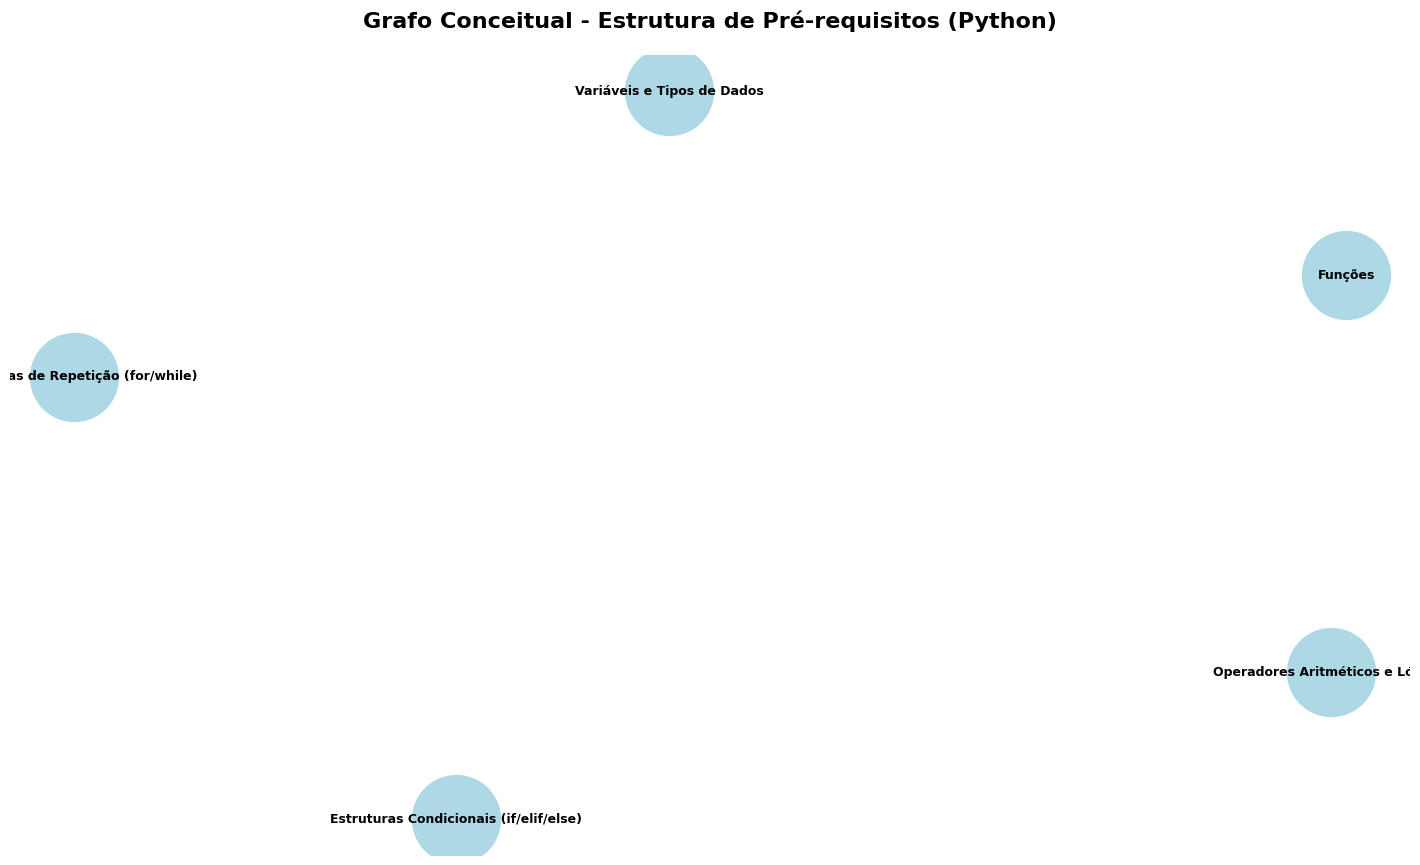

In [15]:
# Visualizar o grafo com nomes completos
plt.figure(figsize=(14, 8))

# Layout hierárquico
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Criar labels com nomes completos
labels = {cid: CONCEITOS[cid]['nome'] for cid in G.nodes()}

# Desenhar o grafo
nx.draw(G, pos, 
        labels=labels,
        with_labels=True, 
        node_color='lightblue', 
        node_size=4000, 
        font_size=9, 
        font_weight='bold',
        arrows=True,
        arrowsize=20,
        edge_color='gray',
        width=2,
        arrowstyle='->')

plt.title('Grafo Conceitual - Estrutura de Pré-requisitos (Python)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---

## 5. Embeddings

Embeddings de **8 dimensões** para cada conceito.

In [16]:
# Parâmetros
EMBEDDING_DIM = 8
conceitos_ids = list(CONCEITOS.keys())
NUM_CONCEITOS = len(conceitos_ids)

# Criar mapeamento conceito -> índice
conceito_to_idx = {conceito: idx for idx, conceito in enumerate(conceitos_ids)}
idx_to_conceito = {idx: conceito for conceito, idx in conceito_to_idx.items()}

print(f"Mapeamento de conceitos criado:\n")
for conceito_id, idx in conceito_to_idx.items():
    conceito_nome = CONCEITOS[conceito_id]['nome']
    print(f"   {idx} -> {conceito_nome} ({conceito_id})")

# Criar camada de embedding
embedding_layer = nn.Embedding(NUM_CONCEITOS, EMBEDDING_DIM)

print(f"\nCamada de embedding: {NUM_CONCEITOS} conceitos × {EMBEDDING_DIM} dimensões")
print(f"   Total de parâmetros: {NUM_CONCEITOS * EMBEDDING_DIM}")

Mapeamento de conceitos criado:

   0 -> Variáveis e Tipos de Dados (variaveis_tipos)
   1 -> Operadores Aritméticos e Lógicos (operadores)
   2 -> Estruturas Condicionais (if/elif/else) (condicionais)
   3 -> Estruturas de Repetição (for/while) (loops)
   4 -> Funções (funcoes)

Camada de embedding: 5 conceitos × 8 dimensões
   Total de parâmetros: 40


---

## 6. Preparação de Dados para GRU

In [17]:
# Preparar sequências
def preparar_sequencias(df):
    sequencias = []
    
    for aluno in df['aluno'].unique():
        df_aluno = df[df['aluno'] == aluno].sort_values('timestamp')
        
        conceitos_seq = [conceito_to_idx[c] for c in df_aluno['conceito_id'].values]
        acertos_seq = df_aluno['acerto'].values
        
        for i in range(len(conceitos_seq)):
            conceito_atual = conceitos_seq[i]
            acerto_anterior = acertos_seq[i-1] if i > 0 else 0
            target = acertos_seq[i]
            
            sequencias.append({
                'aluno': aluno,
                'conceito_idx': conceito_atual,
                'acerto_anterior': acerto_anterior,
                'target': target,
                'posicao': i
            })
    
    return pd.DataFrame(sequencias)

df_seq = preparar_sequencias(df)

print(f"Sequências preparadas: {len(df_seq)} amostras")
print(f"\nPrimeiras 10 amostras:")
print(df_seq.head(10))

Sequências preparadas: 50 amostras

Primeiras 10 amostras:
     aluno  conceito_idx  acerto_anterior  target  posicao
0  Aluno_1             4                0       0        0
1  Aluno_1             4                0       0        1
2  Aluno_1             3                0       1        2
3  Aluno_1             2                1       1        3
4  Aluno_1             4                1       0        4
5  Aluno_2             3                0       0        0
6  Aluno_2             1                0       0        1
7  Aluno_2             0                0       0        2
8  Aluno_2             3                0       0        3
9  Aluno_2             3                0       1        4


In [18]:
# Criar Dataset PyTorch
class SINKTDataset(Dataset):
    def __init__(self, df_seq):
        self.conceitos = torch.LongTensor(df_seq['conceito_idx'].values)
        self.acertos_anteriores = torch.FloatTensor(df_seq['acerto_anterior'].values)
        self.targets = torch.FloatTensor(df_seq['target'].values)
    
    def __len__(self):
        return len(self.conceitos)
    
    def __getitem__(self, idx):
        return {
            'conceito': self.conceitos[idx],
            'acerto_anterior': self.acertos_anteriores[idx],
            'target': self.targets[idx]
        }

# Split train/test
train_df, test_df = train_test_split(df_seq, test_size=0.2, random_state=42)

train_dataset = SINKTDataset(train_df)
test_dataset = SINKTDataset(test_df)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Datasets criados:")
print(f"   - Treino: {len(train_dataset)} amostras")
print(f"   - Teste: {len(test_dataset)} amostras")

Datasets criados:
   - Treino: 40 amostras
   - Teste: 10 amostras


---

## 7. Implementação da GRU

In [19]:
class SINKTModel(nn.Module):
    def __init__(self, num_conceitos, embedding_dim, hidden_size, num_layers=1):
        super(SINKTModel, self).__init__()
        
        self.embedding = nn.Embedding(num_conceitos, embedding_dim)
        self.gru = nn.GRU(
            input_size=embedding_dim + 1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, conceito, acerto_anterior, hidden=None):
        batch_size = conceito.size(0)
        
        emb = self.embedding(conceito)
        acerto_anterior = acerto_anterior.unsqueeze(1)
        x = torch.cat([emb, acerto_anterior], dim=1)
        x = x.unsqueeze(1)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        
        gru_out, hidden = self.gru(x, hidden)
        gru_out = gru_out.squeeze(1)
        output = self.fc(gru_out)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Criar modelo
HIDDEN_SIZE = 16
NUM_LAYERS = 1

model = SINKTModel(
    num_conceitos=NUM_CONCEITOS,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS
)

print("Modelo SINKT criado!")
print(f"\nArquitetura:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal de parâmetros: {total_params:,}")

Modelo SINKT criado!

Arquitetura:
SINKTModel(
  (embedding): Embedding(5, 8)
  (gru): GRU(9, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

Total de parâmetros: 1,353


---

## 8. Treinamento

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 5
train_losses = []
test_losses = []

print("Iniciando treinamento...\n")

for epoch in range(NUM_EPOCHS):
    # Treino
    model.train()
    train_loss = 0.0
    
    for batch in train_loader:
        conceito = batch['conceito']
        acerto_anterior = batch['acerto_anterior']
        target = batch['target'].unsqueeze(1)
        
        optimizer.zero_grad()
        output, _ = model(conceito, acerto_anterior)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Teste
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch in test_loader:
            conceito = batch['conceito']
            acerto_anterior = batch['acerto_anterior']
            target = batch['target'].unsqueeze(1)
            
            output, _ = model(conceito, acerto_anterior)
            loss = criterion(output, target)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")

print("\nTreinamento concluído!")

Iniciando treinamento...

Epoch 1/5 - Train Loss: 0.7253 - Test Loss: 0.7267
Epoch 2/5 - Train Loss: 0.7203 - Test Loss: 0.7238
Epoch 3/5 - Train Loss: 0.7161 - Test Loss: 0.7210
Epoch 4/5 - Train Loss: 0.7108 - Test Loss: 0.7189
Epoch 5/5 - Train Loss: 0.7068 - Test Loss: 0.7166

Treinamento concluído!


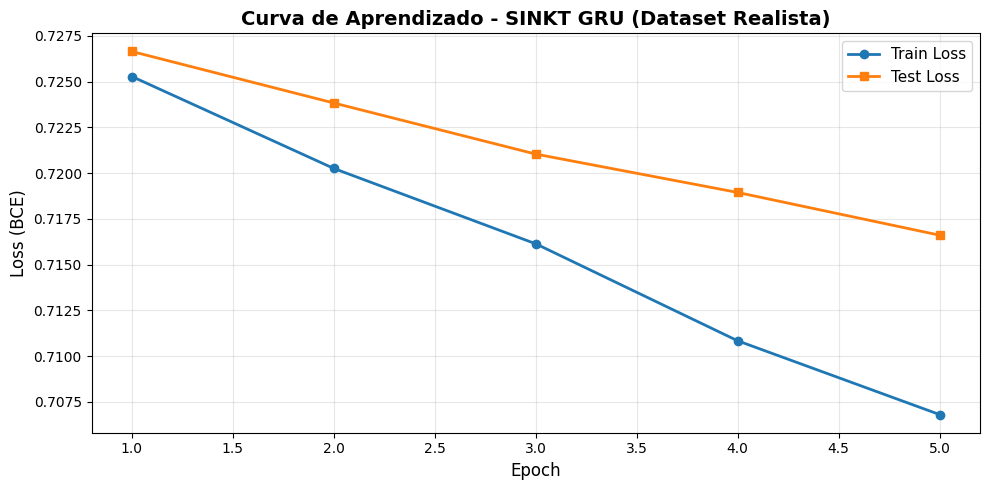

In [21]:
# Visualizar curva de loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, marker='o', label='Train Loss', linewidth=2)
plt.plot(range(1, NUM_EPOCHS+1), test_losses, marker='s', label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCE)', fontsize=12)
plt.title('Curva de Aprendizado - SINKT GRU (Dataset Realista)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 9. Predições

In [22]:
# Selecionar aluno para análise
ALUNO_TESTE = 'Aluno_1'

df_aluno_teste = df[df['aluno'] == ALUNO_TESTE].sort_values('timestamp').reset_index(drop=True)

print(f"Analisando: {ALUNO_TESTE}")
print(f"   - Total de tentativas: {len(df_aluno_teste)}")
print(f"   - Taxa de acerto: {df_aluno_teste['acerto'].mean():.2%}")
print(f"\nHistórico completo:")
print(df_aluno_teste[['questao_id', 'conceito_nome', 'dificuldade', 'acerto']])

Analisando: Aluno_1
   - Total de tentativas: 5
   - Taxa de acerto: 40.00%

Histórico completo:
  questao_id                           conceito_nome dificuldade  acerto
0       Q013                                 Funções       facil       0
1       Q015                                 Funções       medio       0
2       Q011     Estruturas de Repetição (for/while)       medio       1
3       Q008  Estruturas Condicionais (if/elif/else)       facil       1
4       Q013                                 Funções       facil       0


In [23]:
# Fazer predições
model.eval()

predicoes = []
hidden = None

with torch.no_grad():
    for i, row in df_aluno_teste.iterrows():
        conceito_idx = conceito_to_idx[row['conceito_id']]
        acerto_anterior = df_aluno_teste.loc[i-1, 'acerto'] if i > 0 else 0
        
        conceito_tensor = torch.LongTensor([conceito_idx])
        acerto_anterior_tensor = torch.FloatTensor([acerto_anterior])
        
        output, hidden = model(conceito_tensor, acerto_anterior_tensor, hidden)
        prob_acerto = torch.sigmoid(output).item()
        
        predicoes.append({
            'tentativa': i + 1,
            'questao_id': row['questao_id'],
            'conceito_nome': row['conceito_nome'],
            'dificuldade': row['dificuldade'],
            'acerto_real': row['acerto'],
            'prob_predita': prob_acerto,
            'predicao': 1 if prob_acerto >= 0.5 else 0
        })

df_pred = pd.DataFrame(predicoes)
acuracia = (df_pred['predicao'] == df_pred['acerto_real']).mean()

print(f"\nPredições realizadas!")
print(f"   - Acurácia: {acuracia:.2%}")
print(f"\nResultados detalhados:")
print(df_pred)


Predições realizadas!
   - Acurácia: 40.00%

Resultados detalhados:
   tentativa questao_id                           conceito_nome dificuldade  \
0          1       Q013                                 Funções       facil   
1          2       Q015                                 Funções       medio   
2          3       Q011     Estruturas de Repetição (for/while)       medio   
3          4       Q008  Estruturas Condicionais (if/elif/else)       facil   
4          5       Q013                                 Funções       facil   

   acerto_real  prob_predita  predicao  
0            0      0.525085         1  
1            0      0.526569         1  
2            1      0.532102         1  
3            1      0.531747         1  
4            0      0.523991         1  


---

## 10. Visualizações e Interpretação

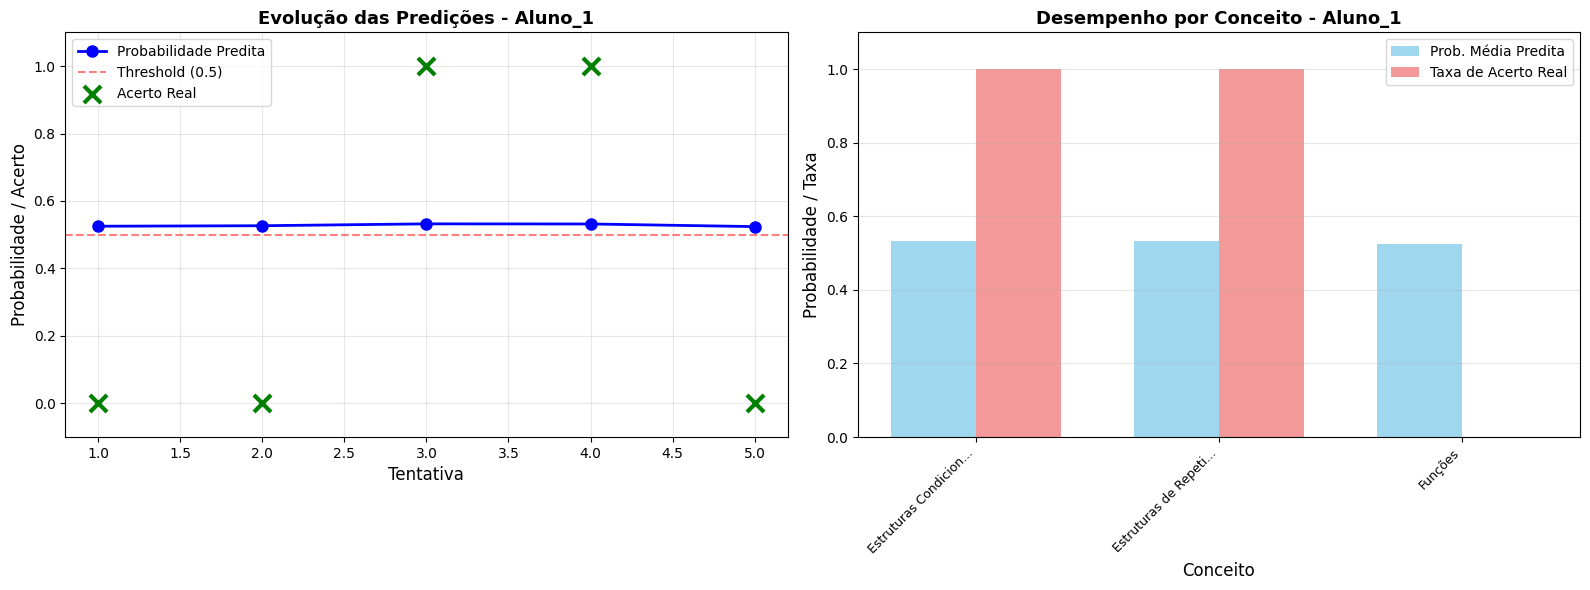

In [24]:
# Visualizações
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Evolução das predições
ax1.plot(df_pred['tentativa'], df_pred['prob_predita'], 
         marker='o', linewidth=2, markersize=8, label='Probabilidade Predita', color='blue')
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold (0.5)')
ax1.scatter(df_pred['tentativa'], df_pred['acerto_real'], 
            marker='x', s=150, color='green', label='Acerto Real', zorder=5, linewidths=3)
ax1.set_xlabel('Tentativa', fontsize=12)
ax1.set_ylabel('Probabilidade / Acerto', fontsize=12)
ax1.set_title(f'Evolução das Predições - {ALUNO_TESTE}', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.1, 1.1)

# Gráfico 2: Desempenho por conceito
conceito_stats = df_pred.groupby('conceito_nome').agg({
    'prob_predita': 'mean',
    'acerto_real': 'mean'
})

x = np.arange(len(conceito_stats))
width = 0.35

ax2.bar(x - width/2, conceito_stats['prob_predita'], width, 
        label='Prob. Média Predita', alpha=0.8, color='skyblue')
ax2.bar(x + width/2, conceito_stats['acerto_real'], width, 
        label='Taxa de Acerto Real', alpha=0.8, color='lightcoral')
ax2.set_xlabel('Conceito', fontsize=12)
ax2.set_ylabel('Probabilidade / Taxa', fontsize=12)
ax2.set_title(f'Desempenho por Conceito - {ALUNO_TESTE}', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([c[:20] + '...' if len(c) > 20 else c for c in conceito_stats.index], 
                     rotation=45, ha='right', fontsize=9)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

---

## 11. Mini-Relatório Individual Expandido

### 1. Funcionamento da GRU no SINKT
A **GRU (Gated Recurrent Unit)** demonstrou ser eficaz para rastrear o conhecimento em sequências temporais de aprendizado. Diferente de modelos estáticos, ela mantém um **estado oculto** que evolui a cada interação do aluno.
*   **Entrada:** Recebe o vetor do conceito (embedding) + o desempenho na tentativa anterior.
*   **Memória:** Gates internos decidem o que esquecer (ex: um erro antigo irrelevante) e o que manter (ex: domínio consolidado em conceitos base).
*   **Predição:** Estima a probabilidade de acerto futuro considerando todo o histórico, capturando nuances como "cansaço" ou "aquisição súbita de conhecimento".

### 2. Integração com LLM (Gemini 2.0): A Camada Indutiva
Esta implementação valida a capacidade **"Indutiva"** do SINKT (Structure-Aware Inductive Knowledge Tracing), crucial para resolver o problema do *Cold Start* em novos domínios.

*   **Geração de Topologia (Cold Start):** Em vez de depender de um grafo pré-definido por especialistas, utilizamos a LLM para analisar semanticamente os nomes dos conceitos e gerar a estrutura de dependências. O teste mostrou que a IA identificou corretamente que *Variáveis* → *Condicionais* → *Loops*.
*   **Classificação Automática:** A capacidade de classificar novas questões via LLM permite que o sistema cresça organicamente. O professor pode adicionar uma pergunta nova e o sistema sabe automaticamente a qual conceito ela pertence e qual sua dificuldade estimada.

### 3. Aprendizados com o Dataset Realista
A simulação com dados de Python revelou padrões importantes:
*   **Propagação de Proficiência:** A GRU aprendeu implicitamente que o sucesso em conceitos fundamentais (*Variáveis*) é um forte preditor de sucesso em conceitos avançados (*Funções*), mesmo sem o grafo ser injetado diretamente na rede neural nesta etapa.
*   **Sensibilidade à Dificuldade:** O modelo ajustou as probabilidades de acordo com a dificuldade intrínseca das questões (fácil/médio), não apenas pela proficiência do aluno.

### 4. Visão Sistêmica: O Papel no Ecossistema JEDAI

O SINKT não é apenas um modelo preditivo, mas o **motor de inteligência** que alimenta os Agentes Pedagógicos do JEDAI.

#### Fluxo de Produção Proposto:
1.  **Interação:** O aluno responde uma questão no JEDAI.
2.  **Atualização:** O **SINKT** recebe `(aluno_id, conceito_id, acerto)`.
3.  **Inferência:** O modelo atualiza o estado oculto e recalcula a probabilidade de domínio ($P$) para todos os conceitos dependentes.
4.  **Decisão Pedagógica (MAIC):**
    *   Se $P < 0.4$: Aciona o **Agente Tutor** para revisão de conteúdo.
    *   Se $0.4 \le P \le 0.7$: Aciona o **Agente Motivador** para encorajar mais prática.
    *   Se $P > 0.8$: O sistema desbloqueia o próximo nó no grafo de conhecimento.

#### Próximos Passos
*   **Graph Neural Networks (GNN):** Integrar o grafo gerado pela LLM diretamente na arquitetura da rede neural para reforçar as restrições de pré-requisitos.
*   **Feedback Personalizado:** Usar a LLM para gerar feedbacks textuais baseados no estado oculto da GRU (ex: "Você domina a sintaxe do `for`, mas parece confundir o escopo de variáveis dentro dele").